In [1]:
from equalityml import FAIR, discrimination_threshold, paired_ttest, binary_threshold_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.base import clone
import numpy as np
import pandas as pd
import warnings

%matplotlib inline
random_seed = 0

### 1. Train a Machine Learning Model

In [2]:
# Dataset Parameters
target_var = 'two_year_recid'
features = ['juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'sex', 'age']

In [3]:
data = pd.read_csv('../data/compas-scores-two-years.csv') 

In [4]:
y = data[target_var]
X = data[features]

In [5]:
X.head()

,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,sex,age
0,0,1,0,0,0,Male,69
1,0,3,0,0,0,Male,34
2,0,4,0,1,4,Male,24
3,0,8,1,0,1,Male,23
4,0,1,0,0,2,Male,43


In [6]:
# Define which columns should be encoded
columns_to_encode = ['sex']

# Instantiate encoder
ohe = OneHotEncoder(sparse=False, drop = 'if_binary')

# Scale 
encoded_data = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
encoded_df = pd.DataFrame(encoded_data, columns = columns_to_encode)

processed_X = pd.concat([X.drop(columns=columns_to_encode), encoded_df], axis=1)
processed_X = pd.DataFrame(processed_X, columns = X.columns)

In [7]:
processed_X.head()

,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,sex,age
0,0,1,0,0,0,1.0,69
1,0,3,0,0,0,1.0,34
2,0,4,0,1,4,1.0,24
3,0,8,1,0,1,1.0,23
4,0,1,0,0,2,1.0,43


In [8]:
# Training and testing dataset split
X_train, X_test, y_train, y_test = train_test_split(processed_X, y, test_size=0.2, random_state=random_seed)

In [9]:
# Train a machine learning model (for example LogisticRegression)
orig_ml_model = LogisticRegression()
orig_ml_model.fit(X_train, y_train)

LogisticRegression()

### 2. Optimal Discrimination Threshold for F1 score

100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


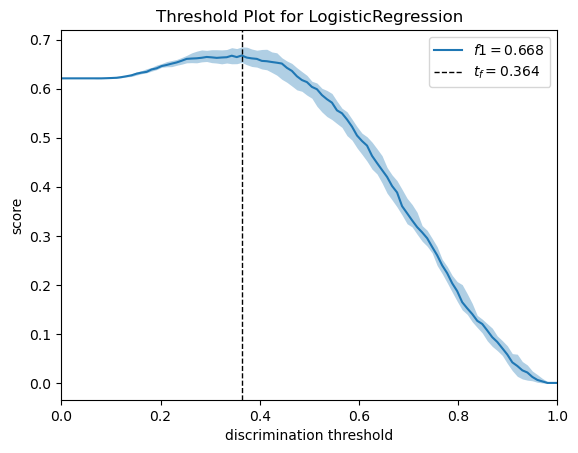

Discrimination Threshold = 0.364


In [10]:
decision_maker = ['f1', 'max']
scoring = "f1"
# Discrimination Threshold
orig_threshold = discrimination_threshold(orig_ml_model, 
                                         processed_X,
                                         y,
                                         decision_maker=decision_maker,
                                         metrics=[decision_maker[0]], 
                                         show=True,
                                         random_seed=random_seed)
print(f"Discrimination Threshold = {orig_threshold:.3f}")

In [11]:
orig_f1_score = binary_threshold_score(orig_ml_model, 
                                        X_test, 
                                        y_test,
                                        scoring=scoring,  
                                        threshold=orig_threshold)
print(f"Original F1 score = {orig_f1_score:.3f}")

Original F1 score = 0.683


### 3. Fairness Metric Assessment

In [12]:
testing_data = pd.concat([X_test, y_test], axis=1)
training_data = pd.concat([X_train, y_train], axis=1)

In [13]:
# Instantiate FAIR object
fair_object = FAIR(ml_model=orig_ml_model,
                   training_data=training_data,
                   testing_data=testing_data, 
                   target_variable=target_var,
                   protected_variable="sex", 
                   privileged_class=1.0,
                   threshold=orig_threshold,
                   random_seed=random_seed) 

In [14]:
metric_name='statistical_parity_ratio'
orig_fairness_metric_score = fair_object.fairness_metric(metric_name)
print(f"Original Fairness Metric = {orig_fairness_metric_score:.3f}")

Original Fairness Metric = 0.633


### 4. Compare Performance of Each Mitigation Method

In [15]:
# Print available bias mitigation methods for statistical_parity_ratio
fair_object.print_bias_mitigation_methods(metric_name)

Available bias mitigation methods for 'statistical_parity_ratio' are:
1 'disparate-impact-remover'
2 'resampling'
3 'resampling-preferential'
4 'reweighing'


In [16]:
df = fair_object.compare_mitigation_methods(metric_name=metric_name, 
                                            scoring=scoring,                                             
                                            show=False,
                                            compute_discrimination_threshold=True,
                                            decision_maker=decision_maker)
print(df)

                                f1  statistical_parity_ratio  \
reference                 0.683181                  0.632963   
disparate-impact-remover  0.685526                  0.624395   
resampling                0.687693                  0.975532   
resampling-preferential   0.684505                  0.874168   
reweighing                0.688545                  0.976120   

                          discrimination_threshold  
reference                                 0.363636  
disparate-impact-remover                  0.363636  
resampling                                0.333333  
resampling-preferential                   0.333333  
reweighing                                0.333333  


### 5. Apply Resampling Mitigation and Re-evaluate F1 Score and Fairness Metric

In [17]:
mitigation_method = "resampling"
mitigation = fair_object.bias_mitigation(mitigation_method = mitigation_method)

# extract modified data 
X_train = mitigation['training_data'][features]
# drop y 
y_train = mitigation['training_data'][target_var]

# Train the second machine learning model using the mitigated dataset
ml_model = clone(orig_ml_model)
ml_model.fit(X_train, y_train)

LogisticRegression()

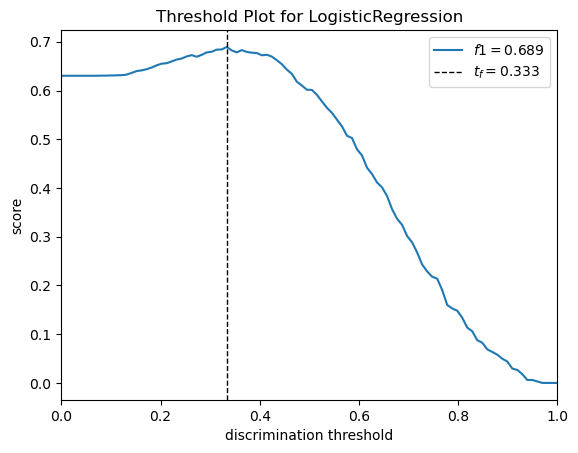

Discrimination Threshold = 0.333


In [18]:
# We can also find the optimal discrimination threshold for this new model
threshold = discrimination_threshold(ml_model, 
                                     X_test,
                                     y_test,
                                     decision_maker=decision_maker,
                                     metrics=[decision_maker[0]], 
                                     show=True,
                                     model_training=False,
                                     random_seed=random_seed)
print(f"Discrimination Threshold = {threshold:.3f}")

In [19]:
f1_score = binary_threshold_score(ml_model, 
                                  X_test, 
                                  y_test,
                                  scoring=scoring, 
                                  threshold=threshold)
print(f"Mitigated F1 score = {f1_score:.3f}")

Mitigated F1 score = 0.689


In [20]:
# Instantiate FAIR object
fair_object = FAIR(ml_model=ml_model,
                   training_data=training_data,
                   testing_data=testing_data, 
                   target_variable=target_var,
                   protected_variable="sex", 
                   privileged_class=1.0,
                   threshold=threshold,
                   random_seed=random_seed) 

In [21]:
fairness_metric_score = fair_object.fairness_metric(metric_name)
print(f"Mitigated Fairness Metric = {fairness_metric_score:.3f}")

Mitigated Fairness Metric = 0.971


In [22]:
print(f"Original F1 score = {orig_f1_score:.3f} and Mitigated F1 score = {f1_score:.3f}")
print(f"Orginal Fairness Score = {orig_fairness_metric_score:.3f} and Mitigated Fairness Score = {fairness_metric_score:.3f}")

Original F1 score = 0.683 and Mitigated F1 score = 0.689
Orginal Fairness Score = 0.633 and Mitigated Fairness Score = 0.971


### 6. Paired t Test

In [23]:
# Paired t test between original Machine Learning model and "applying the mitigation method".
# Fairness metric comparison
results = paired_ttest(orig_ml_model,
                        processed_X,
                        y,
                        method="5x2cv",
                        threshold=orig_threshold,
                        fair_object=fair_object,
                        mitigation_method=mitigation_method,
                        scoring=metric_name,
                        random_seed=random_seed)
print("5x2cv paired t-test using fairness metric. (chi2, p) =", results)

100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

5x2cv paired t-test using fairness metric. (chi2, p) = (-7.5726397407027415, 0.0006370370656437617)


In [24]:
# Paired t test between original Machine Learning model and "applying the mitigation method".
# Fairness metric comparison computing the discrimination threshold
results = paired_ttest(orig_ml_model,
                        processed_X,
                        y,
                        method="5x2cv",
                        fair_object=fair_object,
                        mitigation_method=mitigation_method,
                        scoring=metric_name,
                        compute_discrimination_threshold=True,
                        decision_maker=decision_maker,
                        random_seed=random_seed)
print("5x2cv paired t-test using fairness metric. (chi2, p) =", results)

100%|██████████| 5/5 [00:05<00:00,  1.14s/it]

5x2cv paired t-test using fairness metric. (chi2, p) = (-4.239732269233114, 0.008171698334078475)


In [25]:
# Paired t test between original Machine Learning model and "applying the mitigation method".
# F1 score comparison
results = paired_ttest(orig_ml_model,
                        processed_X,
                        y,
                        method="5x2cv",
                        threshold=orig_threshold,
                        fair_object=fair_object,
                        mitigation_method=mitigation_method,
                        scoring=scoring,
                        random_seed=random_seed)
print("5x2cv paired t-test using F1 metric. (chi2, p) =", results)

100%|██████████| 5/5 [00:01<00:00,  4.39it/s]

5x2cv paired t-test using F1 metric. (chi2, p) = (2.36023417517857, 0.06473221235261217)


In [26]:
# Paired t test between original Machine Learning model and "applying the mitigation method".
# F1 score comparison computing the discrimination threshold
results = paired_ttest(orig_ml_model,
                        processed_X,
                        y,
                        method="5x2cv",
                        fair_object=fair_object,
                        mitigation_method=mitigation_method,
                        scoring=scoring,
                        compute_discrimination_threshold=True,
                        decision_maker=decision_maker,
                        random_seed=random_seed)
print("5x2cv paired t-test using F1 metric. (chi2, p) =", results)

100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

5x2cv paired t-test using F1 metric. (chi2, p) = (0.7378951559332236, 0.4937314596908805)
